In [7]:
import numpy as np
import itertools
import pandas as pd
from scipy.stats import multivariate_normal, norm
import gurobipy as gp
from gurobipy import GRB
from IPython.display import display, Math
from gurobipy import GRB, quicksum
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Simulation Outline

### The proposed weighting estimator using additive balance constraints under a general additive model
##### The proposed weighting estimator using balance constraints under the general additive model assumption (additive balance constraints) and covariate basis functions hs(X) = Xs, s = 1, ... , 5, 

I wrote the forms of the potential outcomes of Y1, Y2, Y3 based on the simulation setting in Section 5 and then calculate their expectations E[Y]. And then followed the Secontion 3.1.1 on the balance constrains we need to optimize using Gurobi to minimize the weighting wi. 

The balance constrains are: 

$$
\sum_{i=1}^{N} w_i A_{i \kappa}^{\Omega} h_s(\mathbf{X}_i) = \sum_{i=1}^{N} h_s(\mathbf{X}_i), \quad \text{for } \Omega = +, - \text{ and } s = 1, \dots, S,
$$

and the factors themselves and the non-negligible interactions as additional "covariates" for balancing such that

$$
\frac{1}{N} \sum_{i=1}^{N} w_i A_{i\kappa}^{\Omega} \prod_{j \in J} Z_{ij} = \frac{1}{2^{K-1}} \sum_{z \in \mathcal{Z}} g_{\kappa z}^{\Omega} \prod_{j \in J} z_j,  \text{ for } \Omega = +,- \text{ and } J \in [K]_{K'}.
$$



After optimization, extract the optimized weights and then first calculate the true factorial effects tau, which the formula is $$\tau_k = \frac{1}{2^{K-1}} \mathbf{g}_k^{\mathrm{T}} \mathbb{E}[\mathbf{Y}]$$ 

Then calculate the estimated weighted factorial effects tua_hat in the Section 2.2 where 


we need to assign a weight of $w_{Z_i}(\mathbf{X}_i)$ to the observed outcome of individual i, determined by the specific treatment combination they received.

Let $w_i = N w_{Z_i}(\mathbf{X}_i)/(2^{K-1} N_{Z_i})$ denote the normalized weights, and let

$$A_{i\kappa}^{+} = \sum_{z \in \mathcal{Z}} g_{\kappa z}^{+} I(Z_i = z), A_{i\kappa}^{-} = \sum_{z \in \mathcal{Z}} g_{\kappa z}^{-} I(Z_i = z) = 1 - A_{i\kappa}^{+}$$

denote whether individual i belongs to the positive or negative part of contrast $\mathbf{g}_\kappa$, respectively.


We estimate the factorial effect $\tau_\kappa$ with the weighting estimator: $\hat{\tau}_\kappa = \hat{\tau}_\kappa^{+} - \hat{\tau}_\kappa^{-}$ , where $$\hat{\tau}_\kappa^{\Omega} = \frac{1}{N} \sum_{i=1}^{N} w_i A_{i\kappa}^{\Omega} Y_i^{\text{obs}}, \quad \text{for } \Omega = +, -.$$

Lastly, calculte the RMSE which The RMSE is calculated as the square root of the average of $(\hat\tau-\tau)^2$.


### The proposed Weighting Estimator with Treatment Effect Heterogeneity: Incorporates interaction balance constraints.
##### The proposed weighting estimator using balance constraints under the outcome model assumption with treatment effect het- erogeneity (interaction balance constraints) and the same set of basis functions as the genearl additive model.




I wrote the forms of the potential outcomes of Y1, Y2, Y3 based on the simulation setting in Section 5 and then calculate their expectations E[Y]. And then followed the Secontion 3.1.1 on the balance constrains we need to optimize using Gurobi to minimize the weighting wi.
 
The balancing constrains are: 
$$
\sum_{i=1}^{N} w_i A_{i \kappa}^{\Omega} \mathbf{q}(\mathbf{X}_i, \mathbf{Z}_i) = \frac{1}{2^{K-1}} \sum_{\mathbf{z} \in \mathcal{Z}} g_{\kappa \mathbf{z}}^{\Omega} \sum_{i=1}^{N} \mathbf{q}(\mathbf{X}_i, \mathbf{z}), \quad \text{for } \Omega = +, -.
$$

After optimization, extract the optimized weights and then first calculate the true factorial effects tau, which the formula is $$\tau_k = \frac{1}{2^{K-1}} \mathbf{g}_k^{\mathrm{T}} \mathbb{E}[\mathbf{Y}]$$

Then calculate the estimated weighted factorial effects tua_hat as the formula shown in the Section 2.2 like the ones above: 

We estimate the factorial effect $\tau_\kappa$ with the weighting estimator: $\hat{\tau}_\kappa = \hat{\tau}_\kappa^{+} - \hat{\tau}_\kappa^{-}$ , where $$\hat{\tau}_\kappa^{\Omega} = \frac{1}{N} \sum_{i=1}^{N} w_i A_{i\kappa}^{\Omega} Y_i^{\text{obs}}, \quad \text{for } \Omega = +, -.$$

Lastly, calculte the RMSE which The RMSE is calculated as the square root of the average of $(\hat\tau-\tau)^2$.

## Simulation Details

### Limitations

During the simulation of the four estimators for each main effect $\tau_\kappa$, where k = 1, 2, 3 under each outcome model, I encountered some problems with Gurobi. 

The largest sample size I can set is N = 200 in order to use Gurobi to optimize the weight. Due to this limitation, Gurobi can not find an optimal weight that balances all the constraints exactly for the balance constraints under the outcome model assumption with treatment effect heterogeneity (interaction balance constraints) because the sample size is too small, the results for RMSE (Weight Heterogeneity) are all NAs after I run the simulate. 

So I used an approximate balance rather than an exact balance for the heterogeneous weighting setup. The main difference is that each equality constraint $\sum_{i \in \mathcal{G}} w_i[...] = \text{target}$ (right side of the balance equation) is replaced by two inequalities allowing a small tolerance $\delta$, so 
$$ -\delta \leq \sum_{i \in \mathcal{G}} w_i [...] - target \leq \delta $$

This way, Gurobi need only achieve the approximate balance, which avoids GurobiError: Model too large for size-limited license and "Model did not find an optimal solution!" outputs. However, the results may not be very accurate due to this approximate balance.

### The Results

### RMSE outputs for estimating three main effects using the four estimators with exact balance setup for interaction weighting:
#### (the largest sample size that does not get a GurobiError is N = 150):

In [6]:
np.random.seed(123)

n_sims = 100 # number of repetitions
N = 150 # sample size
D = 5  # number of covariates
K = 3 # number of binary covariates
rho = 0.0 # correlation
Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)

# coefficient vectors for generating Z 
beta1 = np.array([ 1/4,  2/4,  0.0,  3/4,  1.0])
beta2 = np.array([ 3/4,  1/4,  1.0,  0.0,  2/4])
beta3 = np.array([ 1.0,  0.0,  3/4,  2/4,  1/4])

# Estimate tau_1, tau_2, tau_3 under each outcome model.

def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

def generate_treatments(X):
    Z = np.zeros((X.shape[0], K))
    p1 = logistic(X @ beta1)
    Z1 = (np.random.rand(X.shape[0]) < p1).astype(int)*2 - 1
    Z[:, 0] = Z1

    p2 = logistic(X @ beta2)
    Z2 = (np.random.rand(X.shape[0]) < p2).astype(int)*2 - 1
    Z[:, 1] = Z2

    p3 = logistic(X @ beta3)
    Z3 = (np.random.rand(X.shape[0]) < p3).astype(int)*2 - 1
    Z[:, 2] = Z3

    return Z

def make_contrast_vectors(K):
    from itertools import product
    combos = np.array(list(product([-1,1], repeat=K)))  # shape (8,3)
    # main-effect vectors
    g = {}
    for k in range(K):
        gk = np.where(combos[:, k] == +1, +1, -1)
        g[k+1] = gk
    return g, combos

g_dict, Z_all = make_contrast_vectors(K)  # Z_all is shape (8,3).


def true_main_effects(Yfn, combos=Z_all):
    bigN = 200000
    Xbig = np.random.multivariate_normal(np.zeros(D), Sigma, size=bigN)
    Xbig[:,0] += 0.1
    Xbig[:,1] += 0.1
    Xbig[:,2] += 0.1

    EYZ = np.zeros(len(combos)) 
    for i,z in enumerate(combos):
        Zbig = np.tile(z, (bigN, 1))  # shape (bigN,3)
        Evals = Yfn(Xbig, Zbig)       # now shape (bigN,)
        EYZ[i] = np.mean(Evals)

    tau = {}
    for k in range(1, K+1):
        gk = g_dict[k]
        tau_k = np.mean(gk * EYZ)  
        tau[k] = 2 * tau_k  
    return tau


def Y_model_additive(X, Z):
    sumX = 2 * np.sum(X, axis=1)  # factor 2
    sumZ = np.sum(Z, axis=1)
    return sumX + sumZ

def Y_model_het(X, Z):
    sumX = np.sum(X, axis=1)*2.0
    sumZ = np.sum(Z, axis=1)
    return sumX + (np.sum(X, axis=1)*sumZ)

def Y_model_mis(X, Z):
    X1 = X[:,0]
    X2 = X[:,1]
    part1 = np.sin(X1) + np.cos(X2)
    part2 = (np.minimum(1.0, X1) + X2) * Z[:,0]
    # sum_i(X_i) * sum_{j=2..3}(Z_j)
    part3 = np.sum(X, axis=1) * np.sum(Z[:,1:], axis=1)
    return part1 + part2 + part3

def simulate_Y(X, Z, model="additive"):
    if model=="additive":
        meanY = Y_model_additive(X, Z)
    elif model=="het":
        meanY = Y_model_het(X, Z)
    elif model=="mis":
        meanY = Y_model_mis(X, Z)
    else:
        raise ValueError("Unknown model")
    return meanY + np.random.randn(len(X))  # add normal(0,1)


def solve_weights_additive(X, Z):
    N = X.shape[0]

    # Build A^+_{i,k} and A^-_{i,k}
    # For main effect k, A^+_{i,k} = 1 if Z_{i,k} = +1, else 0
    Aplus = np.where(Z>0, 1.0, 0.0)   # shape (N,K)
    Aminus= 1.0 - Aplus              # shape (N,K)

    sumX = np.sum(X, axis=0)  # shape (D,)

    # Start building the model
    model = gp.Model("AdditiveBalance")
    model.setParam('OutputFlag', 0)  

    # w_i variables
    w_vars = model.addVars(N, vtype=GRB.CONTINUOUS, lb=0.0, name="w")

    # minimize sum_i w_i^2
    obj = gp.quicksum(w_vars[i]*w_vars[i] for i in range(N))
    model.setObjective(obj, GRB.MINIMIZE)

    # add constraints
    # sum_i w_i * Aplus[i,k] * X[i,d] = sumX[d]
    # sum_i w_i * Aminus[i,k]* X[i,d] = sumX[d]
    for k_ in range(K):
        for d_ in range(D):
            lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]*X[i,d_] for i in range(N))
            lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_]*X[i,d_] for i in range(N))
            model.addConstr(lhs_plus  == sumX[d_])
            model.addConstr(lhs_minus == sumX[d_])

    # factor-balance constraints:
    for k_ in range(K):
        lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]  for i in range(N))
        lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_] for i in range(N))
        model.addConstr(lhs_plus  == N)
        model.addConstr(lhs_minus == N)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        print("Model did not find an optimal solution!")
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

def solve_weights_heterogeneous(X, Z):
    N, D = X.shape
    K = Z.shape[1]

    # Aplus[i,k] = 1 if Z_{i,k}=+1 else 0
    Aplus = (Z > 0).astype(float)
    Aminus = 1.0 - Aplus

    intercept = np.ones((N,1))
    Q_list = [intercept, X]  

    # add X_d * Z_k
    XZ = []
    for d_ in range(D):
        for k_ in range(K):
            XZ.append( X[:, d_] * Z[:, k_] )  # shape (N,)
    XZ = np.column_stack(XZ)  # shape (N, D*K)
    Q_list.append(XZ)

    # Combine everything
    Q = np.column_stack(Q_list)  # final shape (N, 1 + D + D*K)

    sumQ = np.sum(Q, axis=0)  # shape (T,)

    model = gp.Model("HeteroBalance")
    model.setParam('OutputFlag', 0)

    w_vars = model.addVars(N, vtype=GRB.CONTINUOUS, lb=0.0, name="w")

    # sum_i w_i^2
    obj = gp.quicksum(w_vars[i]*w_vars[i] for i in range(N))
    model.setObjective(obj, GRB.MINIMIZE)

    # For each factor k, for each column t in Q:
    #   sum_i [w_i * Aplus[i,k] * Q[i,t]] == sumQ[t],
    #   sum_i [w_i * Aminus[i,k]* Q[i,t]] == sumQ[t].
    T = Q.shape[1]
    for k_ in range(K):
        for t_ in range(T):
            lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]*Q[i,t_] for i in range(N))
            lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_]*Q[i,t_] for i in range(N))
            model.addConstr(lhs_plus  == sumQ[t_])
            model.addConstr(lhs_minus == sumQ[t_])

    # factor-balance constraints (like additive case)
    # sum_i w_i Aplus[i,k] = N, sum_i w_i Aminus[i,k] = N
    for k_ in range(K):
        lhs_p = gp.quicksum(w_vars[i]*Aplus[i,k_] for i in range(N))
        lhs_m = gp.quicksum(w_vars[i]*Aminus[i,k_] for i in range(N))
        model.addConstr(lhs_p == N)
        model.addConstr(lhs_m == N)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        #print("Model not optimal!")
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

def estimate_main_effects_weighted(Y, X, Z, w):
    N = len(Y)
    Aplus = (Z>0).astype(float)   # shape (N,K)
    Aminus= 1.0 - Aplus

    tau_est = {}
    for k_ in range(K):
        # \hat{tau}^+_k = (1/N) sum_i w_i A^+_{i,k} Y_i
        tau_plus = np.sum(w * Aplus[:,k_] * Y) / N
        tau_minus= np.sum(w * Aminus[:,k_] * Y) / N
        tau_est[k_+1] = tau_plus - tau_minus
    return tau_est


def additive_regression(Y, X, Z):
    N = len(Y)
    # design: intercept + X + Z (K columns)
    Xd = np.column_stack([np.ones(N), X, Z])
    model = sm.OLS(Y, Xd).fit()
    # The last K coefficients correspond to Z.  Actually the indexing depends on shape(D).
    # intercept: 0, X: 1..D, Z: D+1..D+K
    coefs = model.params
    out = {}
    for k_ in range(K):
        zcoef = coefs[D+1 + k_]
        out[k_+1] = 2*zcoef
    return out

def interaction_regression(Y, X, Z):
    N = len(Y)
    # Build design:
    # columns: 1, X (D of these), Z (K of these), then X_j * Z_k for each j,k
    design_list = []
    design_list.append(np.ones(N))  # intercept
    for d_ in range(D):
        design_list.append(X[:, d_])
    for k_ in range(K):
        design_list.append(Z[:, k_])
    # add interactions X_j * Z_k
    for d_ in range(D):
        for k_ in range(K):
            design_list.append(X[:, d_] * Z[:, k_])
    Xd = np.column_stack(design_list)

    model = sm.OLS(Y, Xd).fit()
    coefs = model.params

    # The main‐effect coefficient for factor k_ is among the first (1 + D + K) terms (the portion for Z_k).
    out = {}
    for k_ in range(K):
        zcoef = coefs[D + 1 + k_]
        out[k_+1] = 2*zcoef
    return out


def run_simulation(n_sims=100, N=2000, model_type="additive"):
    # For storing results
    tauhats_addreg  = []
    tauhats_intreg  = []
    tauhats_weightA = []  
    tauhats_whet    = []

    if model_type == "additive":
        Yfn = Y_model_additive
    elif model_type == "het":
        Yfn = Y_model_het
    elif model_type == "mis":
        Yfn = Y_model_mis
    else:
        raise ValueError("Unknown model_type")
    
    true_tau = true_main_effects(Yfn)

    for sim in range(n_sims):
        # generate X
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0]).T
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)

        # generate Z
        Z_ = generate_treatments(Xraw)

        # simulate Y
        Y_ = simulate_Y(Xraw, Z_, model=model_type)

        # 1) additive regression
        est_ar = additive_regression(Y_, Xraw, Z_)
        tauhats_addreg.append([est_ar[1], est_ar[2], est_ar[3]])

        # 2) interaction regression
        est_ir = interaction_regression(Y_, Xraw, Z_)
        tauhats_intreg.append([est_ir[1], est_ir[2], est_ir[3]])

        # 3) weighting (additive constraints)
        wA = solve_weights_additive(Xraw, Z_)
        if wA is None:
            # if solver failed, just skip
            tauhats_weightA.append([np.nan, np.nan, np.nan])
        else:
            estA = estimate_main_effects_weighted(Y_, Xraw, Z_, wA)
            tauhats_weightA.append([estA[1], estA[2], estA[3]])
        # 4) weighting (interaction constrains)
        wH = solve_weights_heterogeneous(Xraw, Z_)
        if wH is None:
            tauhats_whet.append([np.nan, np.nan, np.nan])
        else:
            estH = estimate_main_effects_weighted(Y_, Xraw, Z_, wH)
            tauhats_whet.append([estH[1], estH[2], estH[3]])

    # Convert to arrays
    tauhats_addreg  = np.array(tauhats_addreg)
    tauhats_intreg  = np.array(tauhats_intreg)
    tauhats_weightA = np.array(tauhats_weightA)
    tauhats_whet    = np.array(tauhats_whet)

    # RMSE
    rmse_ar = np.sqrt(np.mean((tauhats_addreg  - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_ir = np.sqrt(np.mean((tauhats_intreg  - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_wa = np.sqrt(np.nanmean((tauhats_weightA- [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_wh = np.sqrt(np.nanmean((tauhats_whet - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))

    return {
        'true_tau': true_tau,
        'rmse_additive_regression': rmse_ar,
        'rmse_interaction_regression': rmse_ir,
        'rmse_weighting_additive': rmse_wa,
        'rmse_weighting_hetero':  rmse_wh
    }


if __name__=="__main__":
    # Example usage: run each model type
    for mtype in ["additive","het","mis"]:
        res = run_simulation(n_sims=n_sims, N=N, model_type=mtype)
        print(f"\nModel type = {mtype}")
        print("True main effects:", res['true_tau'])
        print("RMSE (add. regression):",    res['rmse_additive_regression'])
        print("RMSE (inter. regression):",  res['rmse_interaction_regression'])
        print("RMSE (weighting add.):",     res['rmse_weighting_additive'])
        print("RMSE (Weight Hetero.):",  res['rmse_weighting_hetero'])


/var/folders/3_/4rpg118x5kl_s2bsjcfwflfc0000gn/T/ipykernel_5081/2220104838.py:447: RuntimeWarning: Mean of empty slice
  rmse_wh = np.sqrt(np.nanmean((tauhats_whet - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))



Model type = additive
True main effects: {1: np.float64(2.0), 2: np.float64(2.0), 3: np.float64(2.0)}
RMSE (add. regression): [0.20292603 0.19599354 0.19467241]
RMSE (inter. regression): [0.21123689 0.20836276 0.20720798]
RMSE (weighting add.): [0.62020931 0.57634086 0.67050514]
RMSE (Weight Hetero.): [nan nan nan]

Model type = het
True main effects: {1: np.float64(0.5994480610963768), 2: np.float64(0.5994480610963768), 3: np.float64(0.5994480610963768)}
RMSE (add. regression): [0.79780011 0.77323037 0.69033354]
RMSE (inter. regression): [0.6163207  0.62022501 0.63472543]
RMSE (weighting add.): [0.7876455  0.72261962 0.70493817]
RMSE (Weight Hetero.): [nan nan nan]

Model type = mis
True main effects: {1: np.float64(0.20646065713456263), 2: np.float64(0.6185422521607693), 3: np.float64(0.6185422521607693)}
RMSE (add. regression): [0.59488916 0.80096286 0.66287507]
RMSE (inter. regression): [0.35662495 0.6409795  0.66334748]
RMSE (weighting add.): [0.7062832  0.70904473 0.77405944]
RM

#### The outputs for RMSE (Weight Hetero.) are all nans.

### RMSE outputs for estimating three main effects using the four estimators with approximate balance setup for interaction weighting with a $\delta$ tolerance = 44.0

#### ($\delta$ = 44 is the smallest $\delta$ that does not get nan outputs)

In [ ]:
np.random.seed(123)

n_sims = 100 # number of repetitions
N = 200 # sample size
D = 5  # number of covariates
K = 3 # number of binary covariates
rho = 0.0 # correlation
Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)

# coefficient vectors for generating Z 
beta1 = np.array([ 1/4,  2/4,  0.0,  3/4,  1.0])
beta2 = np.array([ 3/4,  1/4,  1.0,  0.0,  2/4])
beta3 = np.array([ 1.0,  0.0,  3/4,  2/4,  1/4])

# estimate tau_1, tau_2, tau_3 under each outcome model.

def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

def generate_treatments(X):
    Z = np.zeros((X.shape[0], K))
    # For factor 1
    p1 = logistic(X @ beta1)
    Z1 = (np.random.rand(X.shape[0]) < p1).astype(int)*2 - 1
    Z[:, 0] = Z1

    # For factor 2
    p2 = logistic(X @ beta2)
    Z2 = (np.random.rand(X.shape[0]) < p2).astype(int)*2 - 1
    Z[:, 1] = Z2

    # For factor 3
    p3 = logistic(X @ beta3)
    Z3 = (np.random.rand(X.shape[0]) < p3).astype(int)*2 - 1
    Z[:, 2] = Z3

    return Z

def make_contrast_vectors(K):
    from itertools import product
    combos = np.array(list(product([-1,1], repeat=K)))  # shape (8,3)
    # main-effect vectors
    g = {}
    for k in range(K):
        gk = np.where(combos[:, k] == +1, +1, -1)
        g[k+1] = gk
    return g, combos

g_dict, Z_all = make_contrast_vectors(K)  # Z_all is shape (8,3).


def true_main_effects(Yfn, combos=Z_all):
    bigN = 200000
    Xbig = np.random.multivariate_normal(np.zeros(D), Sigma, size=bigN)
    Xbig[:,0] += 0.1
    Xbig[:,1] += 0.1
    Xbig[:,2] += 0.1

    # E[Y(z)] is average over X of E[Y|X,z]
    EYZ = np.zeros(len(combos)) 
    for i,z in enumerate(combos):
        Zbig = np.tile(z, (bigN, 1))  # shape (bigN,3)
        Evals = Yfn(Xbig, Zbig)       # now shape (bigN,)
        EYZ[i] = np.mean(Evals)

    # now compute tau_k
    tau = {}
    for k in range(1, K+1):
        gk = g_dict[k]
        tau_k = np.mean(gk * EYZ) 
        tau[k] = 2 * tau_k 
    return tau


def Y_model_additive(X, Z):
    # X-sum
    sumX = 2 * np.sum(X, axis=1)  # factor 2
    # Z-sum
    sumZ = np.sum(Z, axis=1)
    return sumX + sumZ

def Y_model_het(X, Z):
    sumX = np.sum(X, axis=1)*2.0
    sumZ = np.sum(Z, axis=1)
    return sumX + (np.sum(X, axis=1)*sumZ)

def Y_model_mis(X, Z):
    X1 = X[:,0]
    X2 = X[:,1]
    part1 = np.sin(X1) + np.cos(X2)
    part2 = (np.minimum(1.0, X1) + X2) * Z[:,0]
    # sum_i(X_i) * sum_{j=2..3}(Z_j)
    part3 = np.sum(X, axis=1) * np.sum(Z[:,1:], axis=1)
    return part1 + part2 + part3

def simulate_Y(X, Z, model="additive"):
    if model=="additive":
        meanY = Y_model_additive(X, Z)
    elif model=="het":
        meanY = Y_model_het(X, Z)
    elif model=="mis":
        meanY = Y_model_mis(X, Z)
    else:
        raise ValueError("Unknown model")
    return meanY + np.random.randn(len(X))  

def solve_weights_additive(X, Z):
    N = X.shape[0]

    # Build A^+_{i,k} and A^-_{i,k}
    # For main effect k, A^+_{i,k} = 1 if Z_{i,k} = +1, else 0
    Aplus = np.where(Z>0, 1.0, 0.0)   # shape (N,K)
    Aminus= 1.0 - Aplus              # shape (N,K)

    sumX = np.sum(X, axis=0)  # shape (D,)

    model = gp.Model("AdditiveBalance")
    model.setParam('OutputFlag', 0)  

    # w_i variables
    w_vars = model.addVars(N, vtype=GRB.CONTINUOUS, lb=0.0, name="w")

    # minimize sum_i w_i^2
    obj = gp.quicksum(w_vars[i]*w_vars[i] for i in range(N))
    model.setObjective(obj, GRB.MINIMIZE)

    # add constraints:
    # For each k in [0..K-1], for each d in [0..D-1]:
    # sum_i w_i * Aplus[i,k] * X[i,d] = sumX[d]
    # sum_i w_i * Aminus[i,k]* X[i,d] = sumX[d]
    for k_ in range(K):
        for d_ in range(D):
            lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]*X[i,d_] for i in range(N))
            lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_]*X[i,d_] for i in range(N))
            model.addConstr(lhs_plus  == sumX[d_])
            model.addConstr(lhs_minus == sumX[d_])

    # factor-balance constraints themselves
    for k_ in range(K):
        lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]  for i in range(N))
        lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_] for i in range(N))
        model.addConstr(lhs_plus  == N)
        model.addConstr(lhs_minus == N)

    model.optimize()
    if model.status != GRB.OPTIMAL:
        print("Model did not find an optimal solution!")
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

def solve_weights_heterogeneous_approx(X, Z, delta=1.0):
    n, d = X.shape
    K = Z.shape[1] 

    # For each factor group, we want sum_i w_i * X[i,ell] to be ~ sumX[ell].
    sumX = np.sum(X, axis=0)  # shape (d,)

    sumXZ = {}
    for kprime in range(K):
        sumXZ[kprime] = np.sum(X * Z[:, kprime].reshape(-1,1), axis=0)  # shape (d,)

    # Gurobi model
    m = gp.Model("weights_hetero_approx")
    m.setParam('OutputFlag', 0)  

    w = m.addVars(n, lb=0.0, name="w")

    # minimize sum_i w_i^2 
    obj = gp.quicksum(w[i]*w[i] for i in range(n))
    m.setObjective(obj, GRB.MINIMIZE)

    # approximate-balance constraints:
    #
    # For each factor kf in {0..K-1}:
    #   - the "plus" group is { i : Z[i, kf] == +1 }
    #   - the "minus" group is { i : Z[i, kf] == -1 }
    #
    # 1) Covariates X
    #    sum_{i in plus group} w_i * X[i,ell]  ~  sumX[ell]  within ± delta
    #    sum_{i in minus group} w_i * X[i,ell] ~ sumX[ell]  within ± delta
    #
    # 2) Interactions X[i,ell] * Z[i,kprime]
    #    sum_{i in plus group} w_i * X[i,ell]*Z[i,kprime] ~ sumXZ[kprime][ell], within ± delta
    #    sum_{i in minus group} w_i * X[i,ell]*Z[i,kprime] ~ sumXZ[kprime][ell], within ± delta

    for kf in range(K):
        # Indices for the plus/minus group of factor kf
        plus_indices  = [i for i in range(n) if Z[i,kf] == +1]
        minus_indices = [i for i in range(n) if Z[i,kf] == -1]

        # 1) Covariates
        for ell in range(d):
            lhs_plus = gp.quicksum(w[i]*X[i,ell] for i in plus_indices)
            lhs_minus = gp.quicksum(w[i]*X[i,ell] for i in minus_indices)

            m.addConstr(lhs_plus  >= sumX[ell] - delta)
            m.addConstr(lhs_plus  <= sumX[ell] + delta)
            m.addConstr(lhs_minus >= sumX[ell] - delta)
            m.addConstr(lhs_minus <= sumX[ell] + delta)

        # 2) Factor-covariate interactions
        for kprime in range(K):
            for ell in range(d):
                lhs_plus = gp.quicksum(
                    w[i]*X[i,ell]*Z[i,kprime] for i in plus_indices
                )
                lhs_minus = gp.quicksum(
                    w[i]*X[i,ell]*Z[i,kprime] for i in minus_indices
                )

                target_val = sumXZ[kprime][ell]
                m.addConstr(lhs_plus  >= target_val - delta)
                m.addConstr(lhs_plus  <= target_val + delta)
                m.addConstr(lhs_minus >= target_val - delta)
                m.addConstr(lhs_minus <= target_val + delta)

    m.optimize()

    if m.status == GRB.OPTIMAL:
        w_sol = np.array([w[i].X for i in range(n)])
        return w_sol
    else:
        #print(f"Model not solved to optimality. Status: {m.status}")
        if m.status == GRB.INFEASIBLE:
            pass
        return None


def estimate_main_effects_weighted(Y, X, Z, w):
    N = len(Y)
    Aplus = (Z>0).astype(float)   # shape (N,K)
    Aminus= 1.0 - Aplus

    tau_est = {}
    for k_ in range(K):
        # \hat{tau}^+_k = (1/N) sum_i w_i A^+_{i,k} Y_i
        tau_plus = np.sum(w * Aplus[:,k_] * Y) / N
        tau_minus= np.sum(w * Aminus[:,k_] * Y) / N
        tau_est[k_+1] = tau_plus - tau_minus
    return tau_est


def additive_regression(Y, X, Z):
    N = len(Y)
    Xd = np.column_stack([np.ones(N), X, Z])
    model = sm.OLS(Y, Xd).fit()
    coefs = model.params
    out = {}
    for k_ in range(K):
        zcoef = coefs[D+1 + k_]
        out[k_+1] = 2*zcoef
    return out

def interaction_regression(Y, X, Z):
    N = len(Y)
    design_list = []
    design_list.append(np.ones(N))  # intercept
    for d_ in range(D):
        design_list.append(X[:, d_])
    for k_ in range(K):
        design_list.append(Z[:, k_])
    # add interactions X_j * Z_k
    for d_ in range(D):
        for k_ in range(K):
            design_list.append(X[:, d_] * Z[:, k_])
    Xd = np.column_stack(design_list)

    model = sm.OLS(Y, Xd).fit()
    coefs = model.params

    out = {}
    for k_ in range(K):
        zcoef = coefs[D + 1 + k_]
        out[k_+1] = 2*zcoef
    return out

def run_simulation_approx(n_sims=100, N=2000, model_type="additive"):
    # For storing results
    tauhats_addreg  = []
    tauhats_intreg  = []
    tauhats_weightA = []  
    tauhats_whet    = []

    # First: compute the true tau's in a large Monte Carlo sense.
    if model_type == "additive":
        Yfn = Y_model_additive
    elif model_type == "het":
        Yfn = Y_model_het
    elif model_type == "mis":
        Yfn = Y_model_mis
    else:
        raise ValueError("Unknown model_type")

    true_tau = true_main_effects(Yfn)

    for sim in range(n_sims):
        # generate X
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0]).T
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)

        # generate Z
        Z_ = generate_treatments(Xraw)

        # simulate Y
        Y_ = simulate_Y(Xraw, Z_, model=model_type)

        # 1) additive regression
        est_ar = additive_regression(Y_, Xraw, Z_)
        tauhats_addreg.append([est_ar[1], est_ar[2], est_ar[3]])

        # 2) interaction regression
        est_ir = interaction_regression(Y_, Xraw, Z_)
        tauhats_intreg.append([est_ir[1], est_ir[2], est_ir[3]])

        # 3) weighting (additive constraints)
        wA = solve_weights_additive(Xraw, Z_)
        if wA is None:
            tauhats_weightA.append([np.nan, np.nan, np.nan])
        else:
            estA = estimate_main_effects_weighted(Y_, Xraw, Z_, wA)
            tauhats_weightA.append([estA[1], estA[2], estA[3]])
            
        # 4) weighting (interaction constrains)
        wH = solve_weights_heterogeneous_approx(Xraw, Z_, delta=44.0)
        if wH is None:
            tauhats_whet.append([np.nan, np.nan, np.nan])
        else:
            estH = estimate_main_effects_weighted(Y_, Xraw, Z_, wH)
            tauhats_whet.append([estH[1], estH[2], estH[3]])

    # Convert to arrays
    tauhats_addreg  = np.array(tauhats_addreg)
    tauhats_intreg  = np.array(tauhats_intreg)
    tauhats_weightA = np.array(tauhats_weightA)
    tauhats_whet    = np.array(tauhats_whet)

    # RMSE
    rmse_ar = np.sqrt(np.mean((tauhats_addreg  - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_ir = np.sqrt(np.mean((tauhats_intreg  - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_wa = np.sqrt(np.nanmean((tauhats_weightA- [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_wh = np.sqrt(np.nanmean((tauhats_whet - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))

    return {
        'true_tau': true_tau,
        'rmse_additive_regression': rmse_ar,
        'rmse_interaction_regression': rmse_ir,
        'rmse_weighting_additive': rmse_wa,
        'rmse_weighting_hetero':  rmse_wh
    }


if __name__=="__main__":
    # Example usage: run each model type
    for mtype in ["additive","het","mis"]:
        res_approx = run_simulation_approx(n_sims=n_sims, N=N, model_type=mtype)
        print(f"\nModel type = {mtype}")
        print("True main effects:", res_approx['true_tau'])
        print("RMSE (add. regression):",    res_approx['rmse_additive_regression'])
        print("RMSE (inter. regression):",  res_approx['rmse_interaction_regression'])
        print("RMSE (weighting add.):",     res_approx['rmse_weighting_additive'])
        print("RMSE (Weight Hetero.):",  res_approx['rmse_weighting_hetero'])



Model type = additive
True main effects: {1: np.float64(2.0), 2: np.float64(2.0), 3: np.float64(2.0)}
RMSE (add. regression): [0.16674451 0.16668409 0.13572587]
RMSE (inter. regression): [0.1828015  0.17892195 0.14453705]
RMSE (weighting add.): [0.43336642 0.51095538 0.56777541]
RMSE (Weight Hetero.): [0.55988955 0.5961413  0.5992724 ]

Model type = het
True main effects: {1: np.float64(0.5969215266490874), 2: np.float64(0.5969215266490874), 3: np.float64(0.5969215266490874)}
RMSE (add. regression): [0.68645406 0.64643962 0.6846551 ]
RMSE (inter. regression): [0.64012276 0.604365   0.61318456]
RMSE (weighting add.): [0.59895346 0.67137641 0.67401233]
RMSE (Weight Hetero.): [0.53309982 0.48438887 0.50711445]

Model type = mis
True main effects: {1: np.float64(0.20372300009907796), 2: np.float64(0.6156933803586893), 3: np.float64(0.6156933803586893)}
RMSE (add. regression): [0.568636   0.65443518 0.6581855 ]
RMSE (inter. regression): [0.39688473 0.63397241 0.61117254]
RMSE (weighting ad

### Plot of the root mean squared error (RMSE) for estimating three main effects over 100 repetitions using four estimators when N = 200 and $\rho$ = 0 and $\delta$ = 44

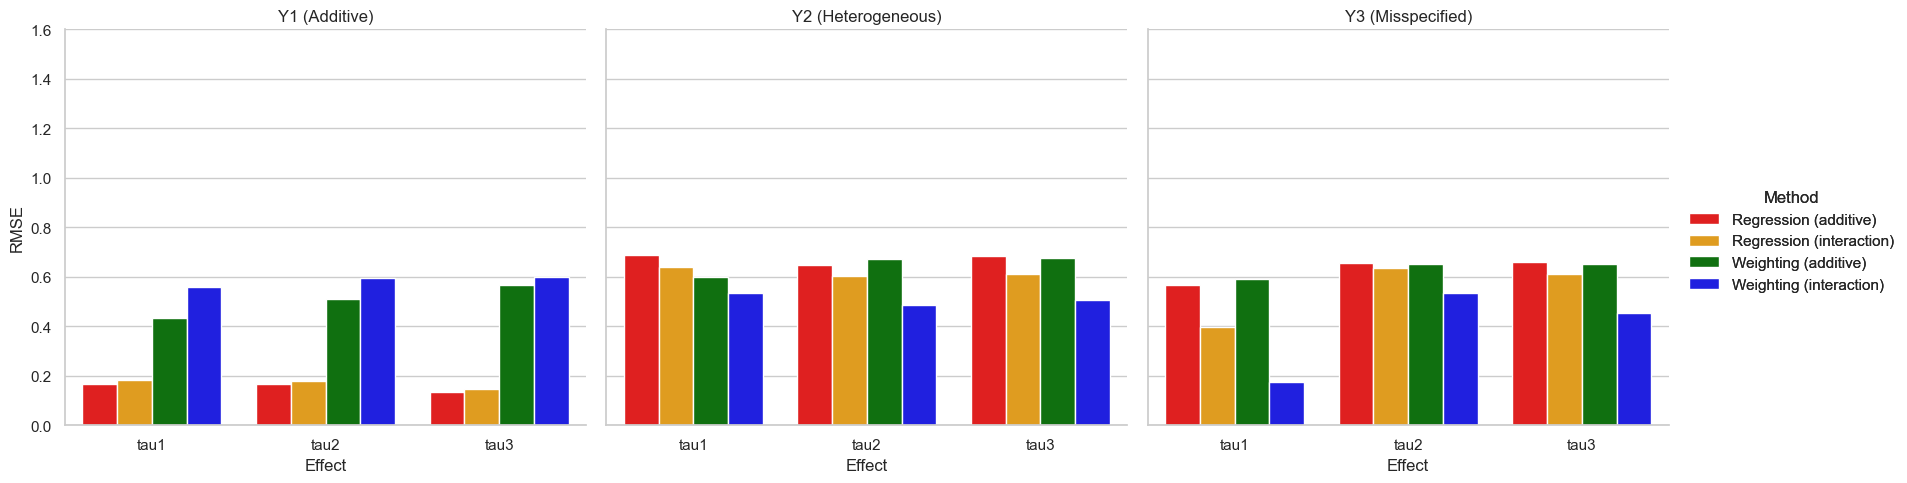

In [5]:
def plot_rmse_comparison_approx(results_dict):
    effects = ['tau1', 'tau2', 'tau3']
    models = {"additive": "Y1 (Additive)", "het": "Y2 (Heterogeneous)", "mis": "Y3 (Misspecified)"}
    
    data = []
    for model_type, rmse_vals in results_dict.items():
        for method, values in rmse_vals.items():
            for i, val in enumerate(values):
                data.append([models[model_type], effects[i], val, method])

    df = pd.DataFrame(data, columns=["Outcome Model", "Effect", "RMSE", "Method"])
    
    # Set style
    sns.set(style="whitegrid")

    # Create FacetGrid bar plot
    g = sns.catplot(
        data=df,
        x="Effect",
        y="RMSE",
        hue="Method",
        col="Outcome Model",
        kind="bar",
        palette=['red', 'orange', 'green', 'blue'],
        height=5,
        aspect=1
    )

    g.set_axis_labels("Effect", "RMSE")
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=0)
    g.add_legend(title="Method")
    g.set(ylim=(0, 1.6))
    
    plt.show()

results_dict = {}

results_dict = {
    "additive": {
        "Regression (additive)": [0.16674451, 0.16668409, 0.13572587],
        "Regression (interaction)": [0.1828015, 0.17892195, 0.14453705],
        "Weighting (additive)": [0.43336642, 0.51095538, 0.56777541],
        "Weighting (interaction)": [0.55988955, 0.5961413, 0.5992724]
    },
    "het": {
        "Regression (additive)": [0.68645406, 0.64643962, 0.6846551],
        "Regression (interaction)": [0.64012276, 0.604365, 0.61318456],
        "Weighting (additive)": [0.59895346, 0.67137641, 0.67401233],
        "Weighting (interaction)": [0.53309982, 0.48438887, 0.50711445]
    },
    "mis": {
        "Regression (additive)": [0.568636, 0.65443518, 0.6581855],
        "Regression (interaction)": [0.39688473, 0.63397241, 0.61117254],
        "Weighting (additive)": [0.59196178, 0.65228133, 0.64987289],
        "Weighting (interaction)": [0.17571767, 0.53443475, 0.45277229]
    }
}

plot_rmse_comparison_approx(results_dict)